In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import matplotlib.pyplot as plt
from tqdm import tqdm

# ================================
# Parameters
# ================================
DATA_PATH = "dataset.xlsx"
TRAIN_SHEET = "T1"      # GPT-2 training dataset
GEN_SHEET = "G_all"        # Generated dataset to evaluate
SMILES_COLUMN = "smiles"

RADIUS = 2              # ECFP4
N_BITS = 2048

# ================================
# Helper: SMILES → Morgan FP
# ================================
def smiles_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, RADIUS, nBits=N_BITS)

# ================================
# Load Data
# ================================
train_df = pd.read_excel(DATA_PATH, sheet_name=TRAIN_SHEET)
gen_df = pd.read_excel(DATA_PATH, sheet_name=GEN_SHEET)

train_smiles = train_df[SMILES_COLUMN].dropna().unique()
gen_smiles = gen_df[SMILES_COLUMN].dropna().unique()

print(f"Training molecules: {len(train_smiles)}")
print(f"Generated molecules: {len(gen_smiles)}")

# ================================
# Compute fingerprints
# ================================
train_fps = []
for smi in tqdm(train_smiles, desc="Training FP"):
    fp = smiles_to_fp(smi)
    if fp:
        train_fps.append(fp)

gen_fps = []
valid_gen_smiles = []
for smi in tqdm(gen_smiles, desc="Generated FP"):
    fp = smiles_to_fp(smi)
    if fp:
        gen_fps.append(fp)
        valid_gen_smiles.append(smi)

print(f"Valid training FP: {len(train_fps)}")
print(f"Valid generated FP: {len(gen_fps)}")

# ================================
# Compute nearest-neighbor similarity
# ================================
max_similarities = []

for gen_fp in tqdm(gen_fps, desc="Computing similarity"):
    sims = DataStructs.BulkTanimotoSimilarity(gen_fp, train_fps)
    max_similarities.append(max(sims))

max_similarities = np.array(max_similarities)

# ================================
# Summary statistics
# ================================
mean_sim = np.mean(max_similarities)
median_sim = np.median(max_similarities)

pct_below_07 = np.sum(max_similarities < 0.7) / len(max_similarities) * 100
pct_below_06 = np.sum(max_similarities < 0.6) / len(max_similarities) * 100
pct_above_085 = np.sum(max_similarities > 0.85) / len(max_similarities) * 100

print("\n==== Similarity Summary ====")
print(f"Mean similarity: {mean_sim:.3f}")
print(f"Median similarity: {median_sim:.3f}")
print(f"% < 0.6: {pct_below_06:.2f}%")
print(f"% < 0.7: {pct_below_07:.2f}%")
print(f"% > 0.85: {pct_above_085:.2f}%")


Training molecules: 11084
Generated molecules: 104005


Training FP:   0%|          | 0/11084 [00:00<?, ?it/s][16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[16:58:26] DEPRECATION WARNING: please use MorganGenerator
[1

Valid training FP: 11084
Valid generated FP: 103207


Computing similarity: 100%|██████████| 103207/103207 [01:59<00:00, 864.32it/s]


==== Similarity Summary ====
Mean similarity: 0.520
Median similarity: 0.513
% < 0.6: 66.71%
% < 0.7: 85.56%
% > 0.85: 2.37%


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_hist_kde_frequency(
    data,
    outpath="tanimoto_hist_kde.png",
    xlabel="Maximum Similarity",
    ylabel="Frequency",
    title=None,
    bins=30,
    xlim=(0.0, 1.0),
    ylim=None,
    xticks=np.arange(0.0, 1.01, 0.2),
    yticks=None,
    bar_color="green",
    line_color="blue",
    alpha=0.5,
    bw_method="scott",
    figsize=(5, 5),
    dpi=500
):
    data = np.asarray(data, dtype=float)
    data = data[np.isfinite(data)]

    plt.figure(figsize=figsize)

    # histogram (frequency)
    counts, bin_edges, _ = plt.hist(
        data,
        bins=bins,
        color=bar_color,
        edgecolor=bar_color,
        alpha=alpha
    )

    # KDE scaled to frequency
    kde = gaussian_kde(data, bw_method=bw_method)
    x_vals = np.linspace(bin_edges[0], bin_edges[-1], 1000)
    kde_vals = kde(x_vals)
    bin_width = bin_edges[1] - bin_edges[0]
    kde_scaled = kde_vals * len(data) * bin_width
    plt.plot(x_vals, kde_scaled, color=line_color, linewidth=1)

    # labels
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    if title:
        plt.title(title, fontsize=16)

    # axes
    plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)

    if xticks is not None:
        plt.xticks(xticks, fontsize=16)
    else:
        plt.xticks(fontsize=16)

    if yticks is not None:
        plt.yticks(yticks, fontsize=16)
    else:
        plt.yticks(fontsize=16)

    # clean look
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)

    plt.tight_layout()
    plt.savefig(outpath, dpi=dpi, bbox_inches="tight")
    plt.show()


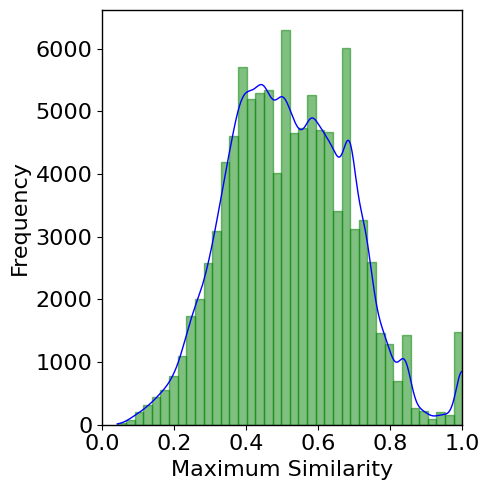

In [3]:

# Plot
plot_hist_kde_frequency(max_similarities,
                        outpath="all_tanimoto_hist.jpg",
                        bins=40,
                        xlim=(0, 1),
                        xticks=np.arange(0, 1.01, 0.2))